# What is Dask? 

<div>
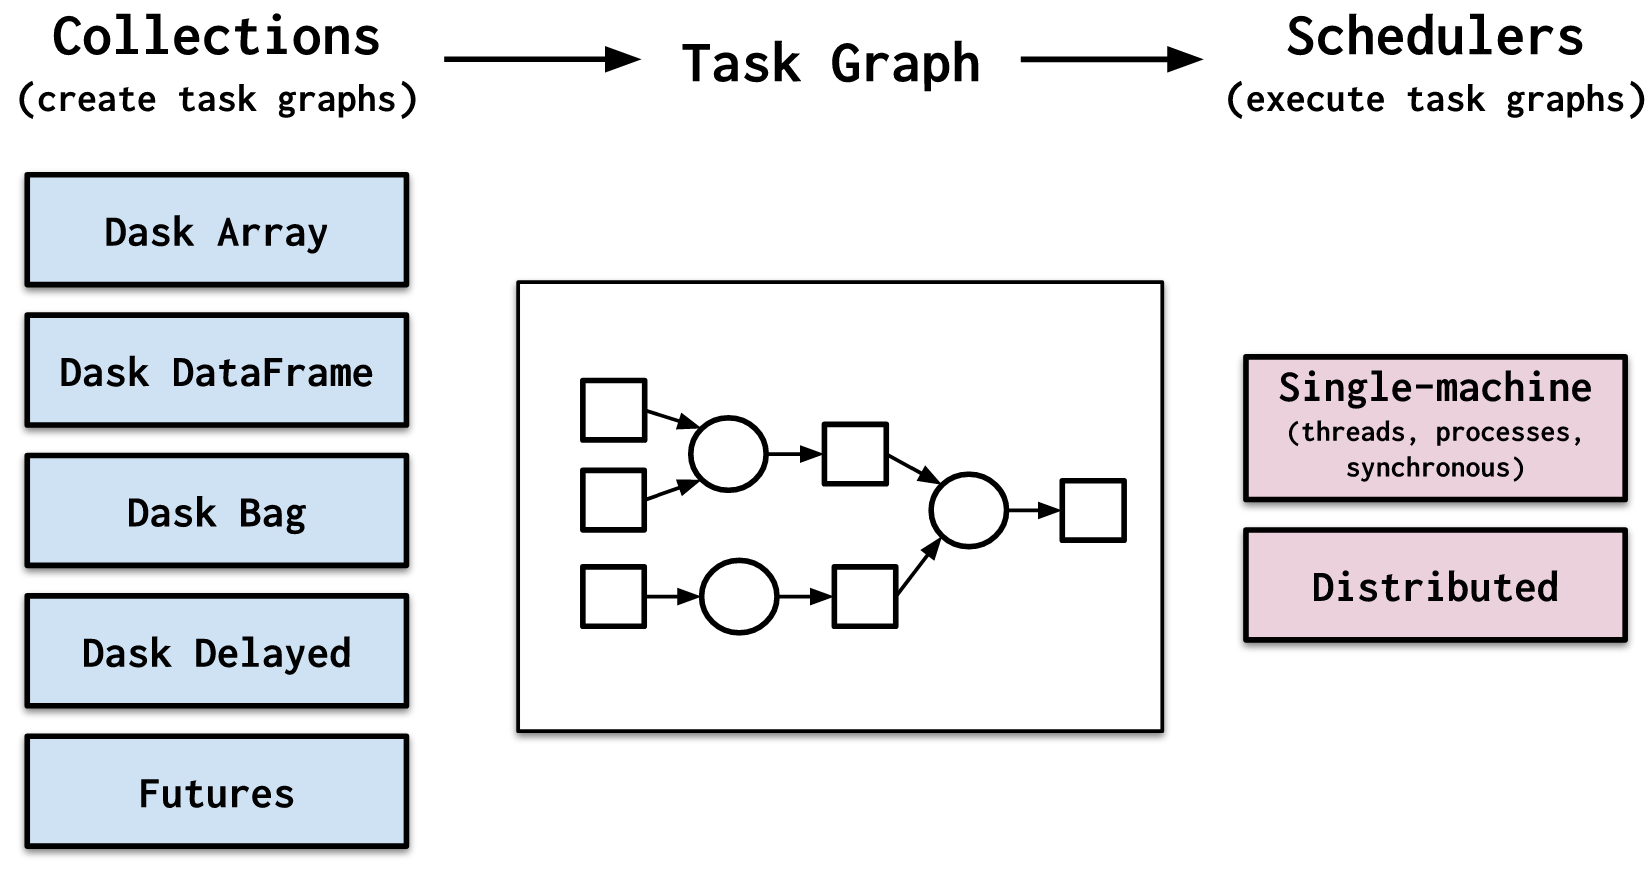
</div>

Here are the basic aspects of Dask, according to dask's package maintainers:
- process data that doesn't fit into memory by breaking it into blocks and specifying task chains
- parallelize execution of tasks across cores and even nodes of a cluster
- move computation to the data rather than the other way around, to minimize communication overhead




## Dask is a graph execution engine

Let us open the same file as we opened previously, but with a fewer number of chunks, to make it easier to visualize. We just have 4 chunks in the temperature field 

In [6]:
import xarray as xr
filename='/scratch/training/intro_pangeo/datasets/B.E.13.B1950TRC5.ne120_t12.cesm-ihesp-1950-2050.013/ocn/hist/B.E.13.B1950TRC5.ne120_t12.cesm-ihesp-1950-2050.013.pop.h.nday1.2021-01-01.nc'
ds = xr.open_dataset(filename, chunks={'nlat':1200,'nlon':1800, 'time':16})
ds.SST

<xarray.DataArray 'SST' (time: 31, nlat: 2400, nlon: 3600)>
dask.array<open_dataset-f316e8b74123d50171962cd0ae795226SST, shape=(31, 2400, 3600), dtype=float32, chunksize=(16, 1200, 1800), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2021-01-02 00:00:00 ... 2021-02-01 00:00:00
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(1200, 1800), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(1200, 1800), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(1200, 1800), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(1200, 1800), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Surface Potential Temperature
    units:         degC
    grid_loc:      2110
    cell_methods:  time: mean



When ds.mean is called, dask first partitions this mean operation into a series of small tasks to operate on each chunk.  But before we do, let's reopen the dataset with a fewer number of chunks, so that it's easier to visualize. We just have 4 chunks in the temperature field  

It will be useful to take a look at the task graph generated by dask. Below is an example of a dask graph generated when we call the mean operation on the temperature field in the dataset.

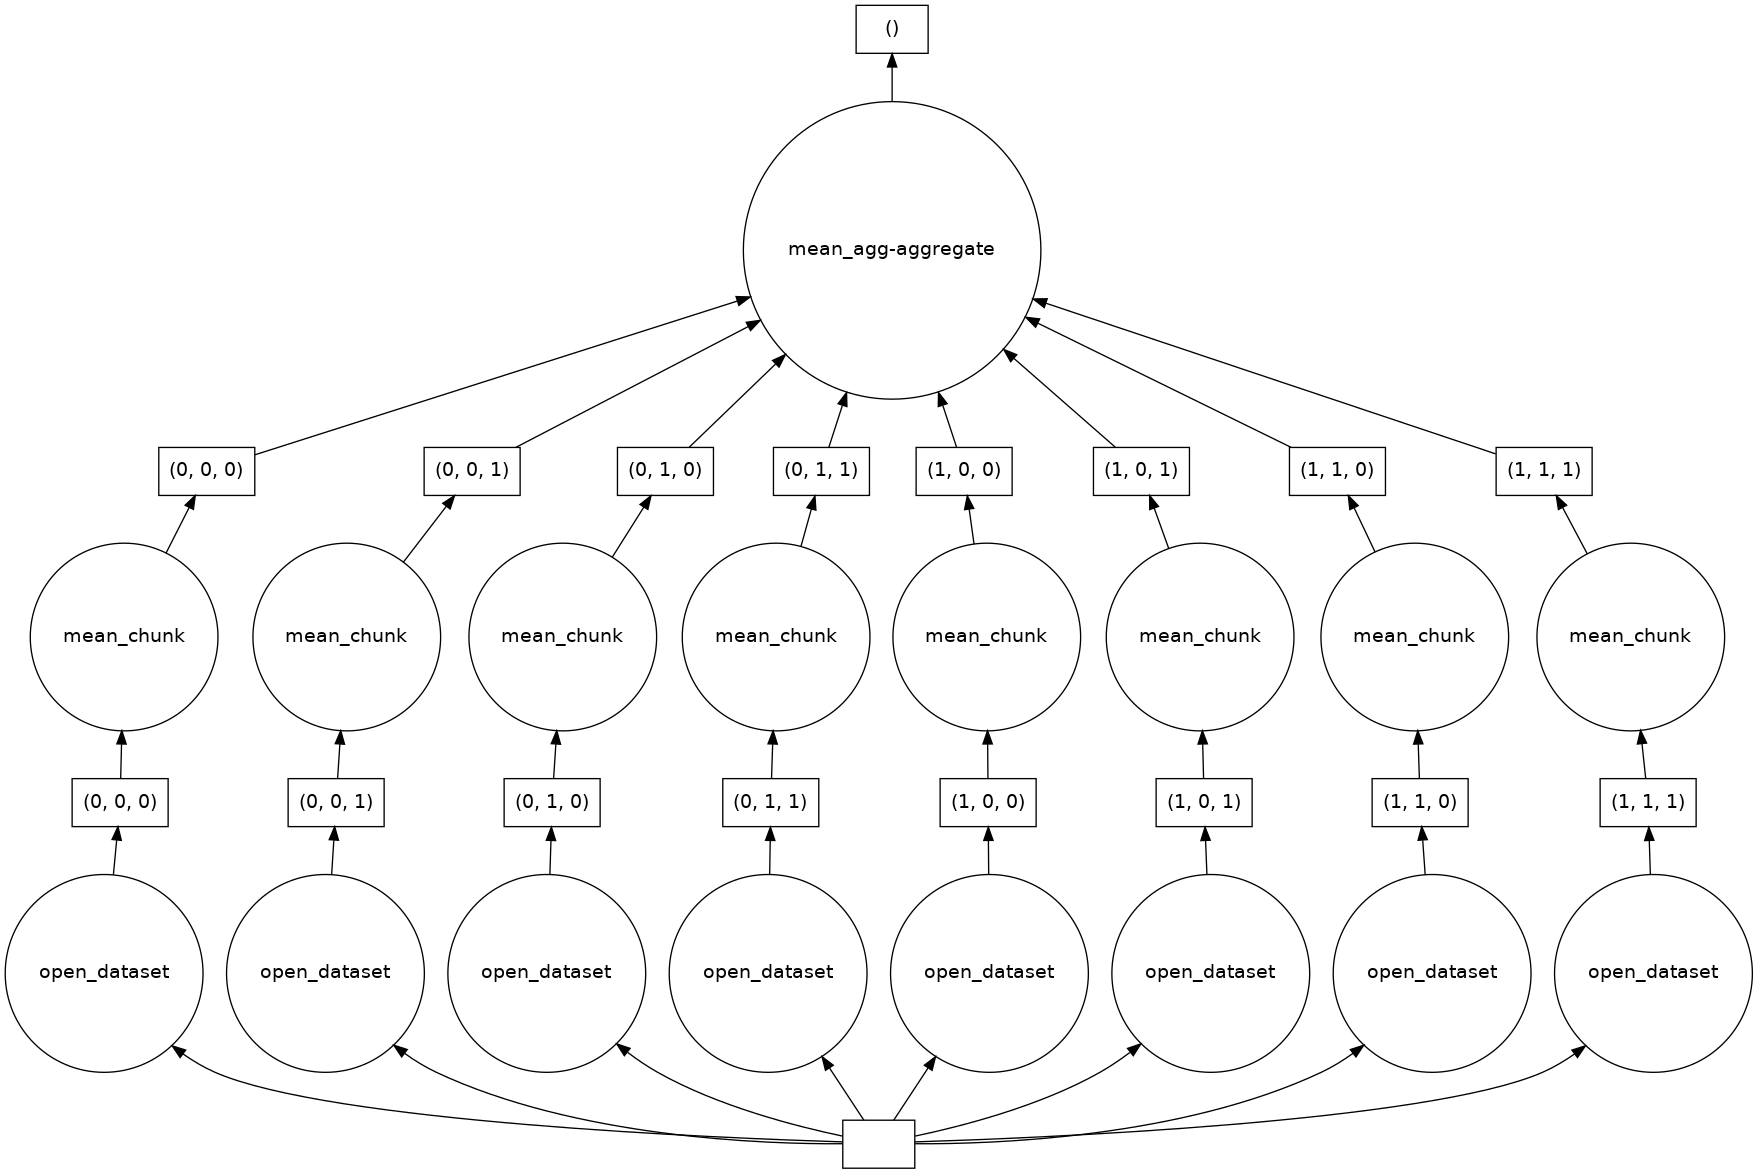

In [7]:
import dask
import matplotlib.pyplot as plt
%matplotlib inline
dask.visualize(ds.SST.mean())
#ds.close()

As we saw previously, there are 4 chunks in the dataset we opened. Dask loads each chunk into memory, and calls the mean_chunk function to generate the required sum and number of elements in the chunk, and aggregates the values in the mean_agg step. 

During the compute() operation, the dask scheduler basically assigns or schedules each task in the graph (circle) to operate on data (rectangle). The scheduler optimally assigns tasks to processors that already have the respective chunk in memory. When it runs out of new chunks to process, dask loads more chunks into memory through open_dataset. Since dask assigns these tasks to all available processors by default, this means that operation we just executed is **inherently parallel**.

Here's a nice example of [simulated complex ETL](https://blog.dask.org/2017/01/24/dask-custom) work flow. 

![this](images/grid_search_schedule.gif)


## Dask Schedulers

The Dask _Schedulers_ orchestrate the tasks in the Task Graphs so that they can
be run in parallel. _How_ they run in parallel, though, is determined by which
_Scheduler_ you choose.

There are 3 _local_ schedulers:

- **Single-Thread Local:** For debugging, profiling, and diagnosing issues
- **Multi-threaded:** Using the Python built-in `threading` package (the default
  for all Dask operations except `Bags`)
- **Multi-process:** Using the Python built-in `multiprocessing` package (the
  default for Dask `Bags`)

and 1 _distributed_ scheduler, which we will talk about later:

- **Distributed:** Using the `dask.distributed` module (which uses `tornado` for
  communication over TCP). The distributed scheduler uses a `Cluster` to manage
  communication between the scheduler and the "workers". This is described in
  the next section.

### Distributed Clusters (http://distributed.dask.org/)

- `LocalCluster` - Creates a `Cluster` that can be executed locally. Each
  `Cluster` includes a `Scheduler` and `Worker`s.
- `Client` - Connects to and drives computation on a distributed `Cluster`





## Dask default single-machine scheduler

When the compute() function is called, dask uses a default single-machine scheduler to provide task parallelism. Specifically, dask runs the mean function on a single process with multiple-threads, which is equivalent to saying more exlicitly average_ds.compute(scheduler='threads'). The work among the 4 chunks in the previous step would be distributed among 4 threads on a single process. 

Dask can also spread work among different processes instead of threads, by using average_ds.compute(scheduler='processes'). This can be advantageous in certain situations. See: https://docs.dask.org/en/latest/setup/single-machine.html

Finally, you can also force dask to run the entire work on a single thread by using average_ds.compute(scheduler='single-threaded'). For the previous example, a single thread would execute the entire task graph by looping over the graph.

In [31]:
#average_ds.compute(scheduler='processes')
#average_ds.compute(scheduler='single-threaded').

## Dask distributed scheduler - single machine

Dask also comes with a much more sophisticated distributed scheduler, that has been designed to scale across hundreds of compute nodes (and thousands of cores). For several reasons, it is also preferable to use this scheduler for a single machine. See: https://docs.dask.org/en/latest/setup/single-distributed.html. Most importantly, it comes with a dashboard that helps diagnose problems with performance. 

To start the distributed scheduler, we can simply do 

In [1]:
from dask.distributed import Client
client = Client(n_workers=4,threads_per_worker=4,memory_limit='2GB')
client

Client Scheduler: tcp://127.0.0.1:46491 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 7.45 GiB


With the client = Client() statement, the distributed scheduler has registered itself as the default Dask scheduler. We see that the above statement has created a Dask "cluster" with 2 workers (processes, in this case) each containing 2 threads, and 2GB of memory. 

We will do an mean computation just to take a look at the dashboard. 

In [ ]:
ds = xr.open_dataset(infile, chunks={'nlat':400,'nlon':600})
ds.SALT.mean().compute()

 The dashboard will look something like this
  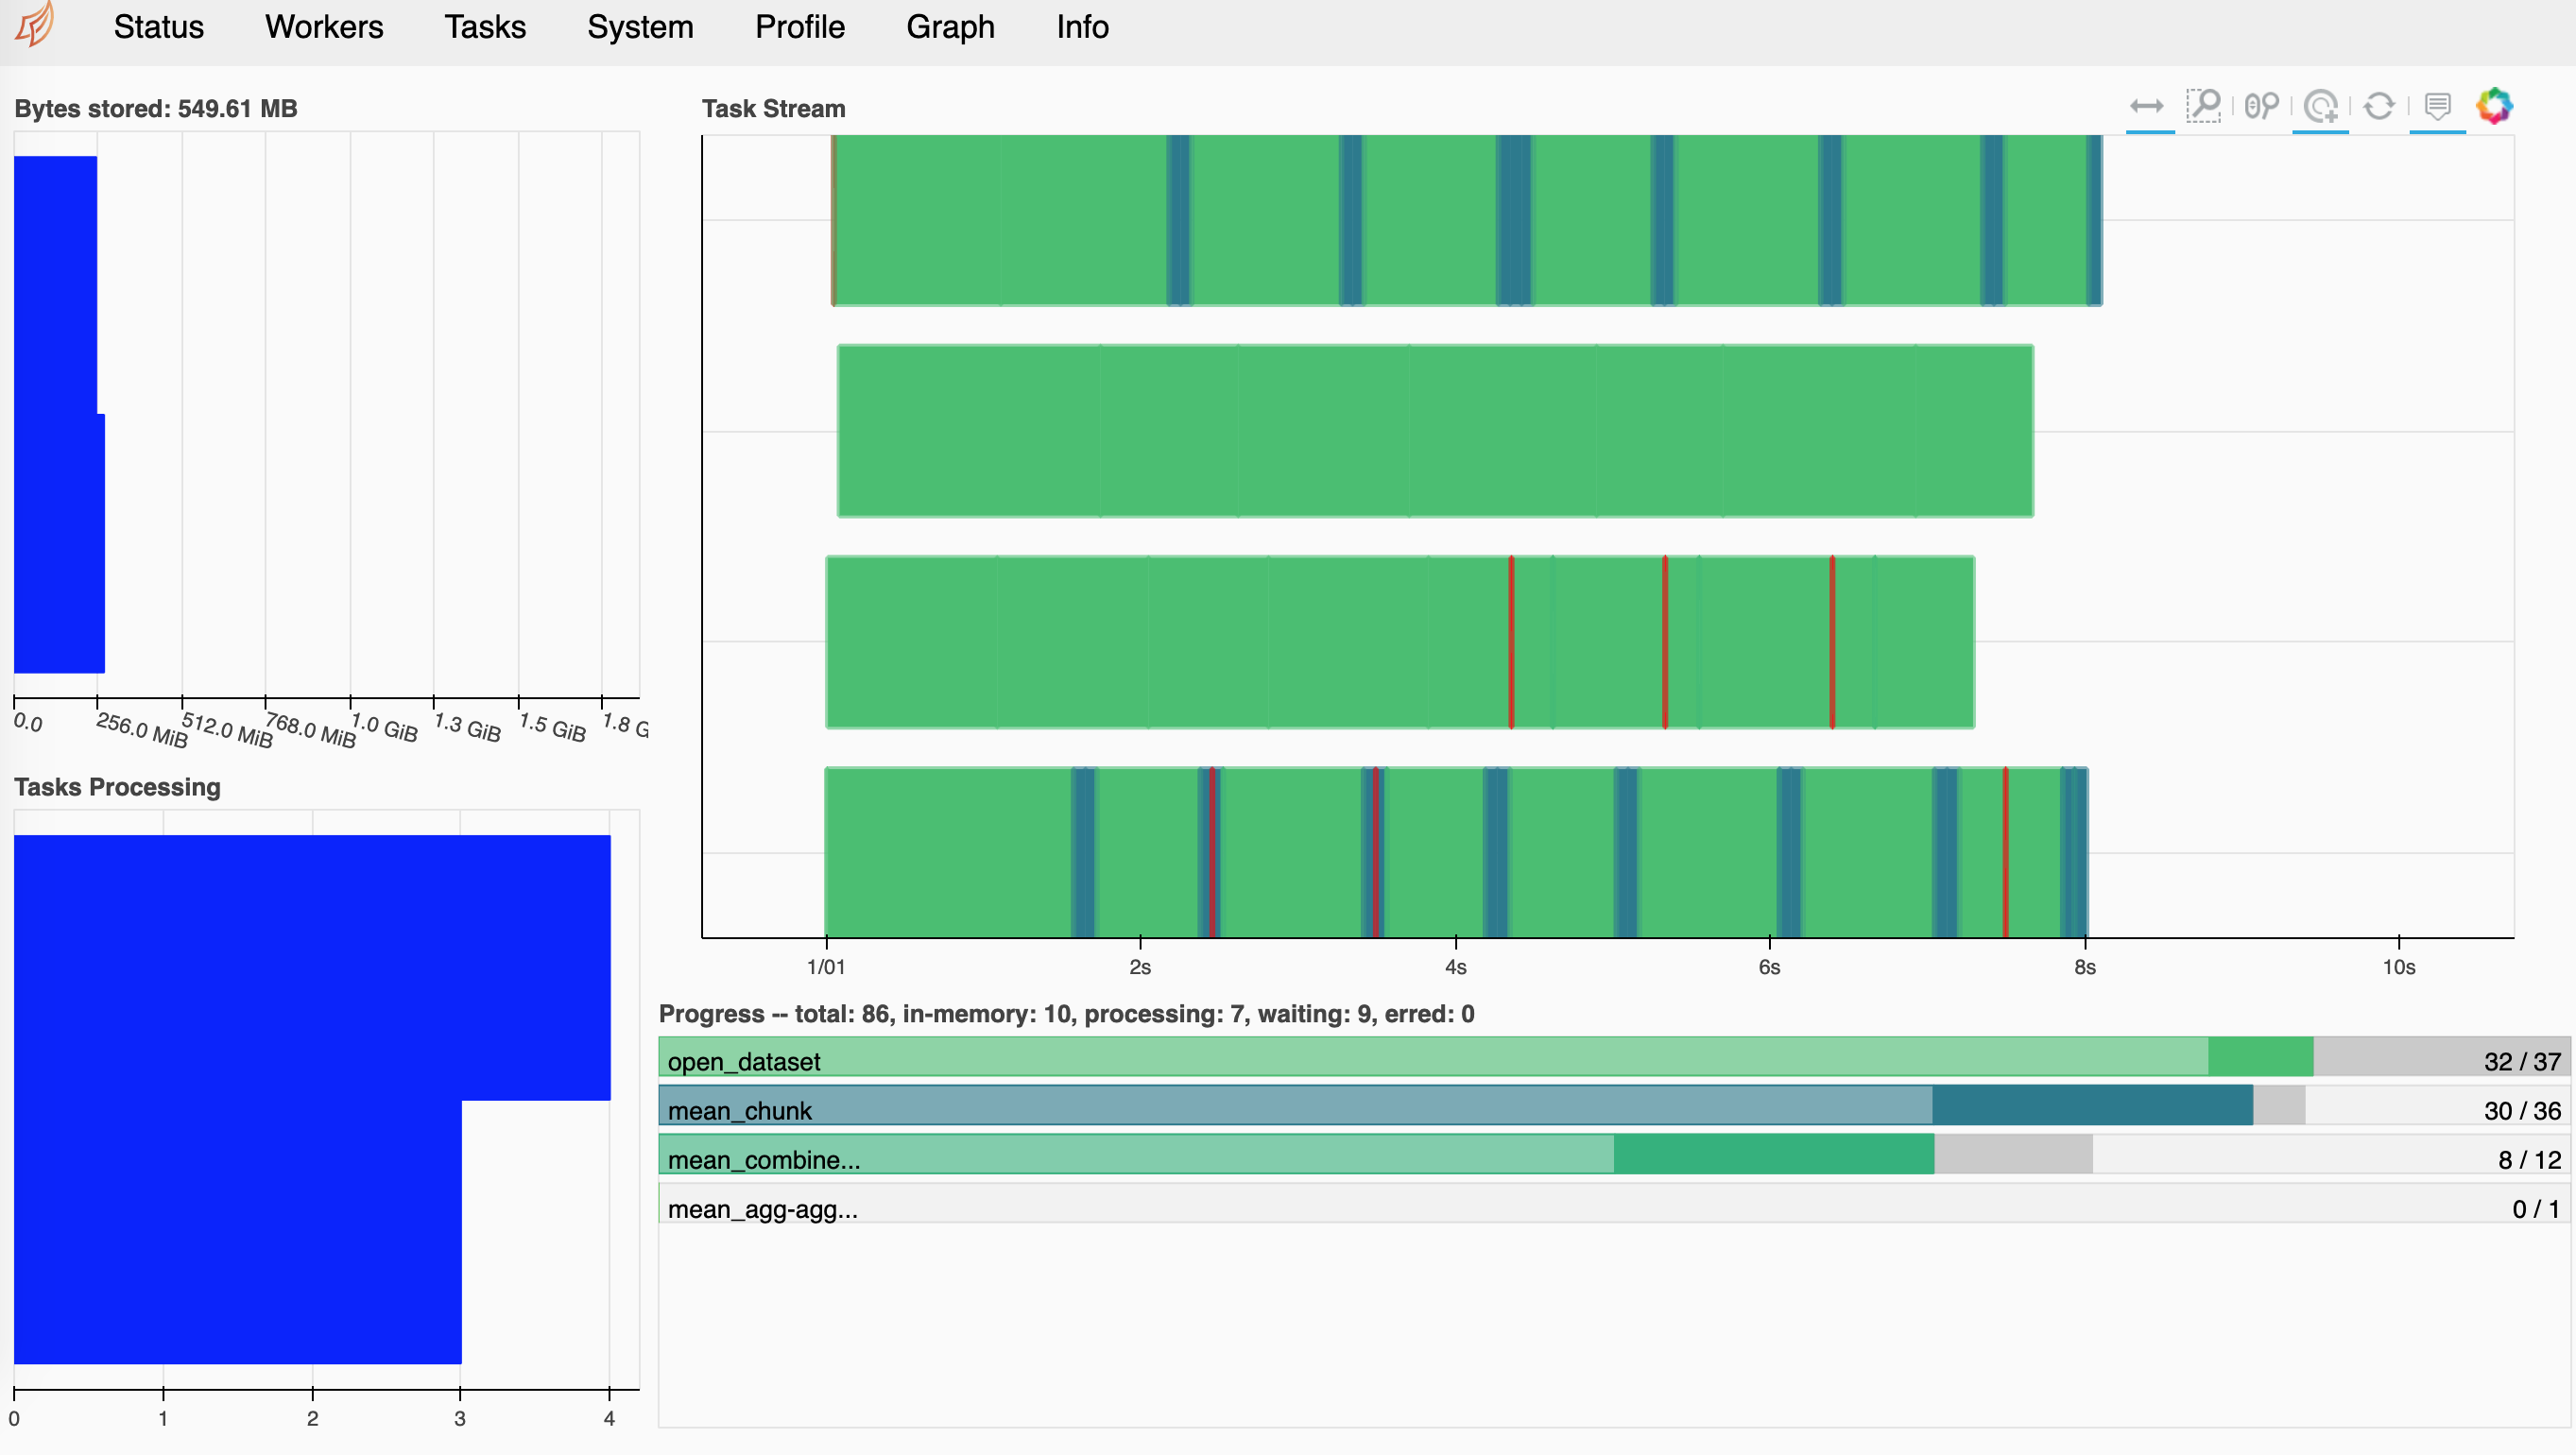



Any operations to the xarray dataset object, will use the distributed cluster from here on out, until it is stopped explicitly by the statement

In [37]:
client.shutdown()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError


## Dask performance report

To save an offline version of the performance dashboard. **Requires the distributed scheduler, and an active distibuted client object**. Doesn't save dynamic progress bars. 

In [10]:
from dask.distributed import performance_report
with performance_report(filename="mean_performance.html"):
    ds.SALT.mean().compute()

CPU times: user 3.44 s, sys: 252 ms, total: 3.69 s
Wall time: 1min 58s


<a id='applymap'></a>

## Automatic parallelization with apply_ufunc and map_blocks

Almost all of xarray’s built-in operations work on Dask arrays.

Sometimes analysis calls for functions that aren't in xarray's API (e.g. scipy).
There are three ways to apply these functions in parallel on each block of your
xarray object:

1. Extract Dask arrays from xarray objects (`.data`) and use Dask directly e.g.
   (`apply_gufunc`, `map_blocks`, `map_overlap`, or `blockwise`)

2. Use `xarray.apply_ufunc()` to apply functions that consume and return NumPy
   arrays.

3. Use `xarray.map_blocks()`, `Dataset.map_blocks()` or `DataArray.map_blocks()`
   to apply functions that consume and return xarray objects.

Which method you use ultimately depends on the type of input objects expected by
the function you're wrapping, and the level of performance or convenience you
desire.

### `map_blocks`

`map_blocks` is inspired by the `dask.array` function of the same name and lets
you map a function on blocks of the xarray object (including Datasets!).

At _compute_ time, your function will receive an xarray object with concrete
(computed) values along with appropriate metadata. This function should return
an xarray object.

Here is an example

In [ ]:
def time_mean(obj):
    # use xarray's convenient API here
    # you could convert to a pandas dataframe and use pandas' extensive API
    # or use .plot() and plt.savefig to save visualizations to disk in parallel.
    return obj.mean("lat")


ds.map_blocks(time_mean)  # this is lazy!

### When all else fails,.... dask.delayed

In [ ]:
def double(x):
    sleep(1)
    return 2 * x

def is_even(x):
    return not x % 2

data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

results = []
for x in data:
    if is_even(x):  # even
        y = delayed(double)(x)
    else:          # odd
        y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)

## When is Dask not useful

**1. If your problem size fits easily in memory, and the computation time is acceptably low, consider using NumPy instead.**
     
      The overhead of using a Dask scheduler starts paying off for larger problems, but NumPy has better performance for smaller ones.
      
**2. If you just want better single-node performance for your python code, consider using Numba instead.**      

      Numba converts Python functions to optimized machine code at runtime, with speeds approaching C or FORTRAN. Numba also provides simplified threading, vectorization and GPU acceleration. You can also combine Numba with Dask for optimal performance.

**3. You do not want to deal with the nuances of lazy loading, chunking, task graphs, etc.**      
 
      Dask enables parallel computing for the simplest tasks automatically, but for complex algorithms, you do need to understand how dask graphs are scheduled, etc. Beginners to parallel programming might find MPI more straightforward than Dask. 

Read about some best practices for Dask: https://docs.dask.org/en/latest/array-best-practices.html